# 10.9.1 A Single Layer Network on the Hitters Data

Set up the data, and separate out a training and test set.

In [1]:
library(ISLR2)
Gitters <- na.omit(Hitters)
n <- nrow(Gitters)
set.seed(13)
ntest <- trunc(n / 3)
testid <- sample(1:n, ntest)

The linear model should be familiar, but we present it anyway.

In [2]:
lfit <- lm(Salary ~ ., data = Gitters[-testid,])
lpred <- predict(lfit, Gitters[testid,])
with(Gitters[testid,], mean(abs(lpred - Salary)))

[1] 254.6687

Notice the use of the `with()` command: the first argument is a dataframe, and the second an expression that can refer to elements of the dataframe by name. In this instance the dataframe corresponds to the test data and the expression computes the mean absolute prediction error on this data.

Next we fit the lasso using `glmnet`. Since this package does not use formulas, we create `x` and `y` first.

In [3]:
x <- scale(model.matrix(Salary ~ . - 1, data = Gitters))
y <- Gitters$Salary

The first line makes a call to `model.matrix()`, which produces the same matrix that was used by `lm()` (the `-1` omits the intercept). This function automatically converts factors to dummy variables. This `scale()` function standarizes the matrix so each column has mean zero and variance one.

In [4]:
library(glmnet)
cvfit <- cv.glmnet(x[-testid,], y[-testid], type.measure = "mae")
cpred <- predict(cvfit, x[testid,], s = "lambda.min")
mean(abs(y[testid] - cpred))

Loading required package: Matrix

Loaded glmnet 4.1-8



[1] 252.2994

To fit the neural network, we first set up a model structure that describes the network.

In [5]:
library(keras)
modnn <- keras_model_sequential() %>%
    layer_dense(units = 50, activation = "relu", input_shape = ncol(x)) %>%
    layer_dropout(rate = 0.4) %>%
    layer_dense(units = 1)

We have created a vanilla model object called `modnn`, and have added details about the successive layers in a sequential manner, using the function `keras.model_sequential()`. The _pipe_ operator `%>%` passes the previous term as the first argument to the next function, and returns the result. It allows us to specify the layers of a neural network in a readable form.

We illustrate the use of the pipe operator on a simple example. Earlier we created $x$ using the command

In [6]:
x <- scale(model.matrix(Salary ~ . - 1, data = Gitters))

We first make a matrix, and then we center each of the variables. Compound expressions like this can be difficult to parse. We could have obtained the same result using the pipe operator:

In [7]:
x <- model.matrix(Salary ~ . - 1, data = Gitters) %>% scale()

Using the pipe operator makes it easier to follow the sequence of operations.

We now return to our neural network. Th eobject `modnn` has a single hidden layer with $50$ hidden units, and a ReLU activation function. It then has a dropout layer, in which a random $40\%$ of teh $50$ activations from the previous layer are set to zero during each iteration of the stochastic gradient descent algorithm. Finally, the output layer has just one unit with no activation function, indicating that the model provides a single quantitative output.

Next we add details to `modnn` that control the fitting algorithm. Here we have simply followed the examples given in the Keras book. We minimize squred-error loss as in (10.23). The algorithm tracks the mean absolute error on the training data, and on validation data if it is supplied.

In [8]:
modnn %>% compile(loss = "mse", optimizer = optimizer_rmsprop(), metrics = list("mean_absolute_error"))

In the previous line, the pipe operator passes `modnn` as the first argument to `compile()`. The `compile()` function does not actually change the `R` object `modnn`, but it does communicate these specifications to the corresponding `python` instance of this model that has been created along the way.

Now we fit the model. We supply the training data and two fitting parameters, `epochs` and `batch_size`. Using $32$ for the latter means that at each step of SGD, the algorithm randomly selects $32$ training observations for the computation of the gradient. Recall from Sections 10.4 and 10.7 that an epoch amounts to the number of SGD steps required to process $n$ observations. Since the training set has $n=176$, an epoch is $176/32=5.5$ SGD steps. The `fit()` function has an argument `validation_data`; these data are not used in the fitting, but can be used to track the progress of the model (in this case reporting the mean absolute error). Here we actually supply the test data so we can see the mean absolute error of both the training data and test data as the epochs proceed. To see more options for fitting, use `?fit.keras.engine.traning.Model`.

In [9]:
history <- modnn %>% fit(
    x[-testid,], y[-testid], epochs = 1500, batch_size = 32,
    validation_data = list(x[testid,], y[testid]))

We can plot the `history` to display the mean absolute error for the training and test data. For the best aesthetics, install the `ggplot2` package before  calling the `plot()` function. If you have not installed `ggplot2`, then the code below will still run.

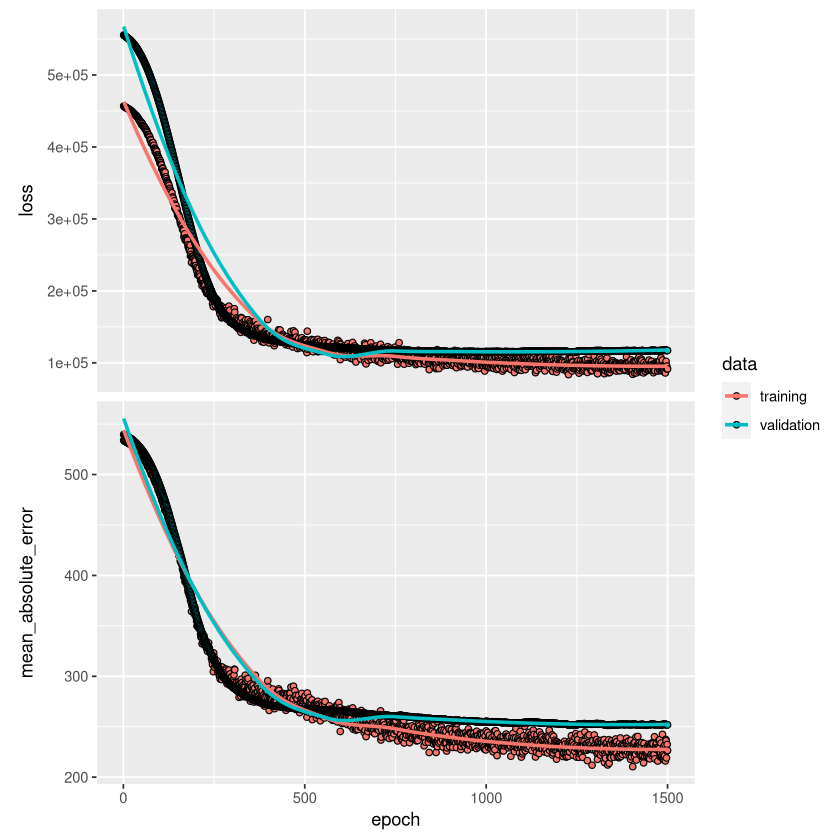

In [10]:
plot(history)

It is worth noting that if you run the `fit()` command a second time in the same R session, then the fitting process will pick up where it left off. Try re-running the `fit()` command, and then the `plot()` command, to see!

Finally, we predict from the final model, and evaluate its performance on the test data. Due to the use of SGD, the result vary slightly with each fit. Unfortunately the `set.seed()` function does not ensure identical results (since the fitting is done in `python`), so your results will differe slightly.

In [11]:
npred <- predict(modnn, x[testid,])
mean(abs(y[testid] - npred))

[1] 251.844